In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

In [3]:
import pandas as pd
import configs

In [4]:
import os

In [5]:
import pickle
with open('hp_search/conf_json3/cnn_confs.pkl', 'rb') as f:
    cnn_confs = pickle.load(f)
with open('hp_search/conf_json3/lstm_confs.pkl', 'rb') as f:
    lstm_confs = pickle.load(f)
with open('hp_search/conf_json3/nochar_confs.pkl', 'rb') as f:
    nochar_confs = pickle.load(f)

In [6]:
len(cnn_confs[0]), len(lstm_confs[0]), len(nochar_confs[0])

(24, 23, 21)

In [7]:
models_folder = 'hp_search/models6'
conf_folder = 'hp_search/conf6'
json_folder = 'hp_search/conf_json6'
logs_folder = 'hp_search/logs6'


In [8]:
if not os.path.exists(models_folder):
    os.mkdir(models_folder)
if not os.path.exists(conf_folder):
    os.mkdir(conf_folder)
if not os.path.exists(json_folder):
    os.mkdir(json_folder)
if not os.path.exists(logs_folder):
    os.mkdir(logs_folder)

In [9]:
import json
def create_all_confs(confs, arch_name, ds_name, emb_name, conf_folder, models_folder, json_folder):
    max_digits = len(str(len(confs)))
    full_confs = []
    for i, conf in enumerate(confs):
        fc = configs.create_conf_file(os.path.join(conf_folder, arch_name+f'.{str(i).zfill(max_digits)}.conf'), 
                                 os.path.join(models_folder, arch_name+f'.{str(i).zfill(max_digits)}.model'), 
                                 ds_name, 
                                 conf, 
                                 emb_name)
        full_confs.append(fc)

    for i, fc in enumerate(full_confs):
        with open( os.path.join(json_folder, arch_name+f'.{str(i).zfill(max_digits)}.json'), 'w') as of:
            of.write(json.dumps(fc))

In [10]:
create_all_confs(lstm_confs, 'morph_charlstm', 'gold_morpheme', 'alt_tok_yap_glove', 
                 conf_folder, models_folder, json_folder)

In [11]:
create_all_confs(cnn_confs, 'morph_charcnn', 'gold_morpheme', 'alt_tok_yap_glove', 
                 conf_folder, models_folder, json_folder)

## Token

In [12]:
create_all_confs(lstm_confs, 'token_charlstm', 'gold_token_bioes', 'alt_tok_tokenized_glove', 
                 conf_folder, models_folder, json_folder)

In [13]:
create_all_confs(cnn_confs, 'token_charcnn', 'gold_token_bioes', 'alt_tok_tokenized_glove', 
                 conf_folder, models_folder, json_folder)

## Token Multi-Tag

In [14]:
create_all_confs(lstm_confs, 'multitok_charlstm', 'gold_token_raw', 'alt_tok_tokenized_glove', 
                 conf_folder, models_folder, json_folder)

In [15]:
create_all_confs(cnn_confs, 'multitok_charcnn', 'gold_token_raw', 'alt_tok_tokenized_glove', 
                 conf_folder, models_folder, json_folder)

## NoChar

In [16]:
create_all_confs(nochar_confs, 'morph_nochar', 'gold_morpheme', 'alt_tok_yap_glove', 
                 conf_folder, models_folder, json_folder)

In [17]:
create_all_confs(nochar_confs, 'token_nochar', 'gold_token_bioes', 'alt_tok_tokenized_glove', 
                 conf_folder, models_folder, json_folder)

In [18]:
create_all_confs(nochar_confs, 'multitok_nochar', 'gold_token_raw', 'alt_tok_tokenized_glove', 
                 conf_folder, models_folder, json_folder)

# RUNNING ON NLP08, NLP10, NLP11, NLP13, NLP05, NLP14
cd NCRFpp/  
conda activate ncrf_gpu  
python run4_hp_search.py 3 token_charlstm.2  


## Check results

In [7]:
import pickle
with open('hp_search/conf_json3/cnn_confs.pkl', 'rb') as f:
    cnn_confs = pickle.load(f)
with open('hp_search/conf_json3/lstm_confs.pkl', 'rb') as f:
    lstm_confs = pickle.load(f)
with open('hp_search/conf_json3/nochar_confs.pkl', 'rb') as f:
    nochar_confs = pickle.load(f)

In [19]:
len(cnn_confs[0]), len(lstm_confs[0]), len(nochar_confs[0])

(24, 23, 21)

In [141]:
import re
import os
DEV_RES_LINE = re.compile('Dev: .*; acc: (?P<acc>[^,]+)(?:, p: (?P<p>[^,]+), r: (?P<r>[^,]+), f: (?P<f>[-\d\.]+))?')
#Dev: time: 0.94s speed: 536.09st/s; acc: 0.9043
#Dev: time: 3.42s, speed: 146.59st/s; acc: 0.9546, p: 0.7577, r: 0.6393, f: 0.6935

mtimes = []
res = []
archs = []
for f in os.scandir('hp_search/logs6'):
    if f.name.startswith('.ipy'):
        continue
    mtimes.append(os.path.getmtime(f.path))
    arch = f.name.split('.')[0]
    archs.append(arch)
    unit = arch.split('_')[0]
    conf_num = f.name.split('.')[1]
    if 'cnn' in arch:
        matching_conf = cnn_confs[int(conf_num)] 
    elif 'lstm' in arch: 
        matching_conf = lstm_confs[int(conf_num)]
    elif 'nochar' in arch:
        matching_conf = nochar_confs[int(conf_num)]
    params = { 'arch': arch, 'unit': unit, 'conf_num': conf_num}
    params.update(matching_conf)
    with open(f.path, 'r') as fp:
        i= 0
        for line in fp:
            m = DEV_RES_LINE.match(line)
            if m:
                r = m.groupdict().copy()
                for k, v in r.items():
                    if v is not None:
                        r[k] = float(v)
                r.update(params)
                r['epoch'] = i
                i+=1
                res.append(r)

rdf = pd.DataFrame(res)

rdf['model_file_name'] = rdf.arch + '.' + rdf.conf_num +'.model.' + rdf.epoch.astype(str) + '.model'
rdf['dset_file_name'] =  rdf.arch + '.' + rdf.conf_num +'.model.dset'
rdf['char_seq_feature'] = rdf.char_seq_feature.fillna('NoChar')

rdf['relevant_score'] = rdf.f.fillna(rdf.acc)

erdf = rdf[(rdf.groupby(['conf_num', 'arch']).relevant_score.transform(max)==rdf.relevant_score) ]
erdf = erdf[(erdf.groupby(['conf_num', 'arch']).epoch.transform(min)==erdf.epoch) ]

In [142]:
erdf.shape

(85, 35)

In [143]:
erdf.groupby('arch').size()

arch
morph_charcnn        21
morph_charlstm        8
morph_nochar          4
multitok_charcnn     14
multitok_charlstm     8
multitok_nochar       4
token_charcnn        14
token_charlstm        8
token_nochar          4
dtype: int64

In [144]:
from collections import Counter
archs = Counter(archs)
archs

Counter({'multitok_nochar': 4,
         'token_nochar': 4,
         'token_charcnn': 14,
         'morph_nochar': 4,
         'multitok_charlstm': 8,
         'multitok_charcnn': 14,
         'token_charlstm': 8,
         'morph_charcnn': 21,
         'morph_charlstm': 8})

In [145]:
print ('Mean time per run:', round((max(mtimes) - min(mtimes) )/ len(mtimes) / 60, 2), 'minutes')

Mean time per run: 23.46 minutes


In [146]:
import numpy as np 
def perc(n):
    def perc_(x):
        return np.percentile(x, n)
    perc_.__name__ = 'perc_%s' % n
    return perc_

erdf.groupby(['unit', 'char_seq_feature']).f.agg(['max', 'min', 'mean', 'std', 'median', perc(95)])

max     min      mean       std   median  \
unit     char_seq_feature                                                
morph    CNN               0.7928  0.7686  0.783452  0.005771  0.78310   
         LSTM              0.7912  0.7707  0.781000  0.006066  0.77990   
         NoChar            0.7617  0.7484  0.756300  0.006050  0.75755   
multitok CNN                  NaN     NaN       NaN       NaN      NaN   
         LSTM                 NaN     NaN       NaN       NaN      NaN   
         NoChar               NaN     NaN       NaN       NaN      NaN   
token    CNN               0.7471  0.7232  0.736307  0.008262  0.73880   
         LSTM              0.7513  0.7292  0.739787  0.008106  0.74085   
         NoChar            0.7014  0.6927  0.698575  0.004084  0.70010   

                            perc_95  
unit     char_seq_feature            
morph    CNN               0.789900  
         LSTM              0.789765  
         NoChar            0.761490  
multitok CNN                    NaN  
         LSTM                   NaN  
         NoChar                 NaN  
token    CNN               0.745865  
         LSTM              0.749655  
         NoChar            0.701385

## Evaluate files (Mention Evaluation)

In [147]:
import sys
sys.path.append('../NER')

In [148]:
import ne_evaluate_mentions as nem

## Create configs for decoding

In [149]:
model_folder = 'hp_search/models6'
output_folder = 'hp_search/decode_output6'
conf_folder = 'hp_search/decode_conf6'
logs_folder = 'hp_search/decode_logs6'

if not os.path.exists(output_folder):
    os.mkdir(output_folder)

if not os.path.exists(conf_folder):
    os.mkdir(conf_folder)
    
if not os.path.exists(logs_folder):
    os.mkdir(logs_folder)
    
decode_sets = {
    'morph': {
        'morph_dev_gold': '../NER/data/for_ncrf/morph_gold_dev.bmes',
        'morph_dev_yap': '../NER/data/for_ncrf/morph_yap_dev_dummy_o.bmes',
        'morph_test_gold': '../NER/data/for_ncrf/morph_gold_test.bmes',
        'morph_test_yap': '../NER/data/for_ncrf/morph_yap_test_dummy_o.bmes',
    },
    'token': {
        'token_dev': '../NER/data/for_ncrf/token_gold_dev_fix.bmes',
        'token_test': '../NER/data/for_ncrf/token_gold_test_fix.bmes',
    },
    'multitok': {
        'token_dev': '../NER/data/for_ncrf/token_gold_dev_concat.bmes',
        'token_test': '../NER/data/for_ncrf/token_gold_test_concat.bmes',
    }
}

params = { 'status': 'decode' }

for i, row in erdf.iterrows():
    unit = row['arch'].split('_')[0]
    for name, set_path in decode_sets[unit].items():
        row_par = params.copy()
        row_par['load_model_dir'] = os.path.join(model_folder, row['model_file_name'])
        row_par['dset_dir'] = os.path.join(model_folder, row['dset_file_name'])
        row_par['decode_dir'] = os.path.join(output_folder, name+'.'+row['arch']+'.'+row['conf_num']+'.bmes')
        row_par['raw_dir'] = set_path
        
        conf_path = os.path.join(conf_folder, name+'.'+row['arch']+'.'+row['conf_num']+'.decode.conf')
        if not os.path.exists(conf_path):
            with open(conf_path, 'w', encoding='utf8') as of:
                for k, v in row_par.items():
                    of.write(k+'='+str(v)+'\n')        
 

## Evaluate decoded folder

In [150]:
scores = {}

In [151]:
if os.path.exists('hp_search/scores6.pkl'):
    scores = pickle.load(open('hp_search/scores6.pkl', 'rb'))

In [152]:
for file in os.scandir(output_folder):
    if file.name=='.ipynb_checkpoints':
        continue
    gold_name, arch, conf_num = file.name.split('.')[:3]
    if (gold_name, arch, conf_num) not in scores:
        _, charsf = arch.split('_')
        if len(gold_name.split('_'))>2:
            unit, pred_set, _ = gold_name.split('_')
            gold_path = decode_sets[unit][unit+'_'+pred_set+'_gold']
        else:
            unit, pred_set = gold_name.split('_')
            gold_path = decode_sets[unit][unit+'_'+pred_set]
        p, r, f = nem.evaluate_files(gold_path, file)
        scores[(gold_name, arch, conf_num)] = (p, r, f)
        
pickle.dump(scores, open('hp_search/scores6.pkl', 'wb'))

In [153]:
score_tups = [(*k, *v) for k,v in scores.items()]

In [154]:
mev = pd.DataFrame(score_tups, columns=('gold_name', 'arch', 'conf_num', 'p', 'r', 'f'))
mev[mev.gold_name.str.contains('dev')].groupby(['gold_name', 'arch']).f.agg(['max', 'min', 'mean', 'std', 'median', perc(95)])

max       min      mean       std  \
gold_name      arch                                                        
morph_dev_gold morph_charcnn      0.794521  0.769394  0.784766  0.006044   
               morph_charlstm     0.792059  0.771520  0.782337  0.005938   
               morph_nochar       0.763359  0.750816  0.757933  0.005804   
morph_dev_yap  morph_charcnn      0.717182  0.683031  0.705310  0.008512   
               morph_charlstm     0.705128  0.696677  0.702280  0.002822   
               morph_nochar       0.689655  0.672586  0.680869  0.006975   
token_dev      multitok_charcnn   0.728832  0.703226  0.719757  0.008446   
               multitok_charlstm  0.736393  0.710084  0.721269  0.009413   
               multitok_nochar    0.706499  0.692390  0.697710  0.006108   
               token_charcnn      0.747065  0.723953  0.736741  0.008328   
               token_charlstm     0.752643  0.729211  0.740862  0.007614   
               token_nochar       0.702128  0.692725  0.699300  0.004407   

                                    median   perc_95  
gold_name      arch                                   
morph_dev_gold morph_charcnn      0.783983  0.791534  
               morph_charlstm     0.781597  0.790596  
               morph_nochar       0.758778  0.763141  
morph_dev_yap  morph_charcnn      0.707027  0.715360  
               morph_charlstm     0.702644  0.704958  
               morph_nochar       0.680617  0.688306  
token_dev      multitok_charcnn   0.721836  0.728582  
               multitok_charlstm  0.721691  0.734152  
               multitok_nochar    0.695975  0.704983  
               token_charcnn      0.739172  0.745868  
               token_charlstm     0.741529  0.750512  
               token_nochar       0.701173  0.701999

In [155]:
mev['pred_set'] = mev.gold_name.apply(lambda x: '_'.join(x.split('_')[1:]).replace('_yap', ''))

In [156]:
mev = mev.set_index(['arch', 'conf_num', 'pred_set'])[['p', 'r', 'f']].unstack()
mev.columns = ['_'.join(col).rstrip('_') for col in mev.columns.values]
mev.head()

p_dev  p_dev_gold    p_test  p_test_gold     r_dev  \
arch          conf_num                                                          
morph_charcnn 00        0.646586    0.730924  0.626609     0.741416  0.757647   
              01        0.656627    0.742972  0.630901     0.758584  0.762238   
              02        0.674699    0.757028  0.630901     0.747854  0.765376   
              03        0.666667    0.757028  0.640558     0.757511  0.752834   
              04        0.660643    0.740964  0.645923     0.768240  0.763341   

                        r_dev_gold    r_test  r_test_gold     f_dev  \
arch          conf_num                                                
morph_charcnn 00          0.834862  0.707879     0.793341  0.697725   
              01          0.829596  0.695858     0.784684  0.705502   
              02          0.835920  0.705036     0.786682  0.717182   
              03          0.826754  0.708185     0.786192  0.707135   
              04          0.832957  0.719235     0.803591  0.708288   

                        f_dev_gold    f_test  f_test_gold  
arch          conf_num                                     
morph_charcnn 00          0.779443  0.664769     0.766500  
              01          0.783898  0.661790     0.771413  
              02          0.794521  0.665912     0.766777  
              03          0.790356  0.672676     0.771585  
              04          0.784272  0.680611     0.785518

In [157]:
erdf = erdf.merge(mev.reset_index(), on=['arch', 'conf_num'])

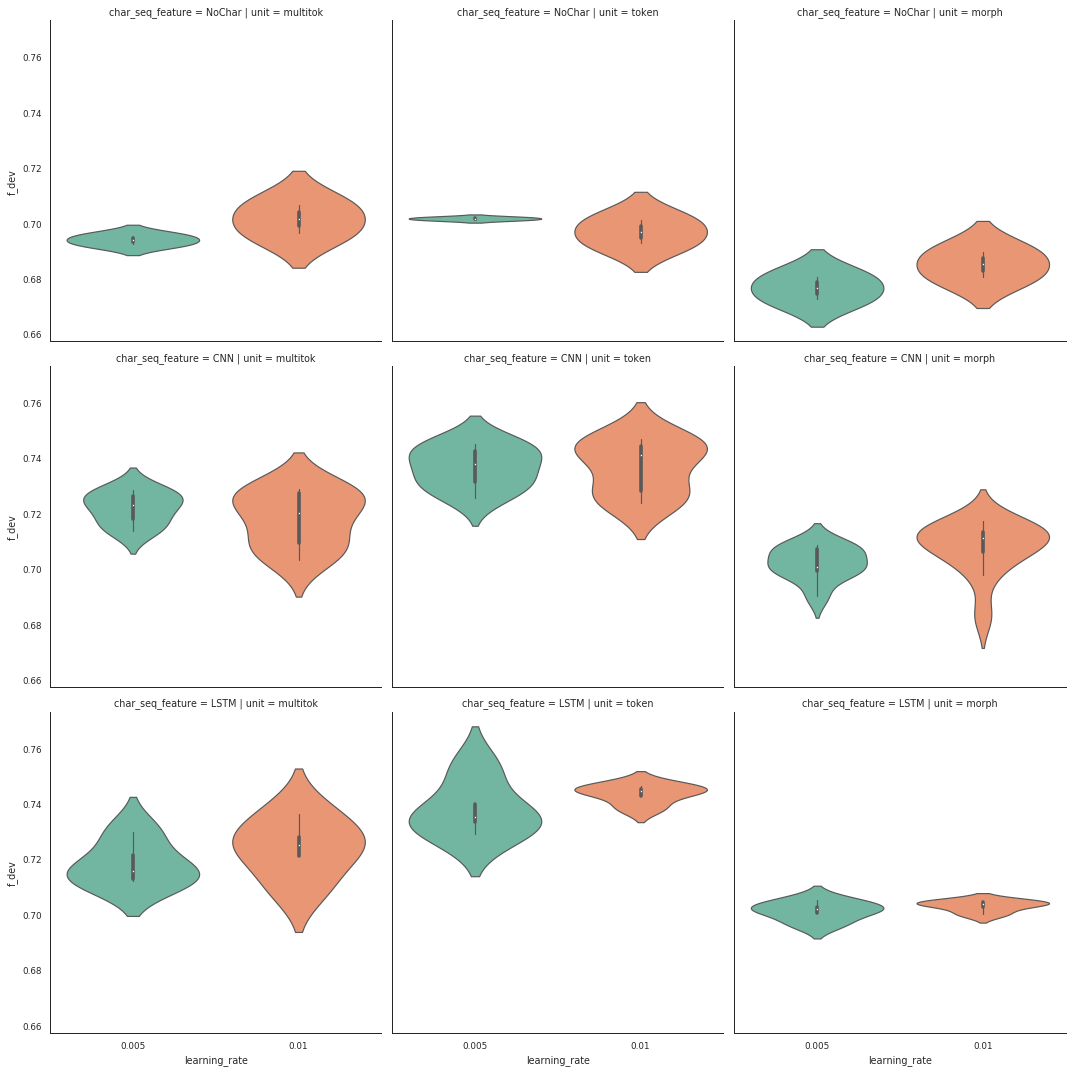

In [158]:
sns.catplot(kind='violin', row='char_seq_feature', col='unit', 
            x="learning_rate", y="f_dev", #hue='batch_size',
                data=erdf, palette="Set2",
                scale="count", inner="box", scale_hue=True)

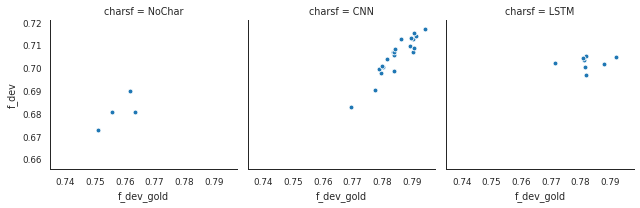

In [159]:
>>> g = sns.FacetGrid(erdf[erdf.unit=='morph'].rename(columns={'learning_rate': 'lr', 'char_seq_feature': 'charsf'}), col='charsf')
>>> g = g.map(plt.scatter, "f_dev_gold", "f_dev", edgecolor="w")

In [115]:
cols = ['f', 'p', 'r', 'char_seq_feature', 'lstm_layer', 'batch_size', 
        'learning_rate', 'char_hidden_dim', 'char_kernel_size',
        'hidden_dim', 'dropout', 'epoch']

In [ ]:
(erdf[erdf.unit=='morph'].sort_values('f', ascending=False).head(20)[['arch', 'conf_num', 'epoch', 'f']]).fillna('')

In [ ]:
(erdf[erdf.unit=='token'].sort_values('f', ascending=False).head(20)[['arch', 'conf_num', 'epoch', 'f']]).fillna('')

In [254]:
(erdf[erdf.unit=='morph'].sort_values('f', ascending=False).head(20)[cols]).fillna('')

,f,p,r,char_seq_feature,lstm_layer,batch_size,learning_rate,char_hidden_dim,char_kernel_size,hidden_dim,dropout,epoch
21,0.8118,0.8591,0.7695,CNN,2,8,0.010,50,5,200,0.4,103
19,0.8075,0.8398,0.7776,NoChar,2,8,0.010,,,200,0.5,107
18,0.8000,0.8475,0.7575,CNN,2,8,0.010,70,7,200,0.4,116
17,0.7996,0.8441,0.7595,LSTM,2,8,0.005,50,,200,0.5,74
22,0.7992,0.8407,0.7615,LSTM,2,8,0.010,70,,200,0.4,92
13,0.7987,0.8472,0.7555,CNN,2,8,0.005,50,7,200,0.4,17
20,0.7979,0.8555,0.7475,CNN,2,8,0.010,50,5,200,0.5,124
23,0.7975,0.8370,0.7615,LSTM,2,8,0.005,70,,200,0.4,104
34,0.7962,0.8516,0.7475,CNN,2,8,0.005,70,3,200,0.5,84
32,0.7941,0.8344,0.7575,LSTM,2,8,0.005,50,,200,0.4,130


In [255]:
(erdf[erdf.unit=='morph'].sort_values('f', ascending=True).head(20)[cols]).fillna('')

,f,p,r,char_seq_feature,lstm_layer,batch_size,learning_rate,char_hidden_dim,char_kernel_size,hidden_dim,dropout,epoch
35,0.7895,0.8315,0.7515,CNN,2,8,0.005,50,7,200,0.5,87
8,0.7920,0.8322,0.7555,NoChar,2,8,0.005,,,200,0.4,29
32,0.7941,0.8344,0.7575,LSTM,2,8,0.005,50,,200,0.4,130
34,0.7962,0.8516,0.7475,CNN,2,8,0.005,70,3,200,0.5,84
23,0.7975,0.8370,0.7615,LSTM,2,8,0.005,70,,200,0.4,104
20,0.7979,0.8555,0.7475,CNN,2,8,0.010,50,5,200,0.5,124
13,0.7987,0.8472,0.7555,CNN,2,8,0.005,50,7,200,0.4,17
22,0.7992,0.8407,0.7615,LSTM,2,8,0.010,70,,200,0.4,92
17,0.7996,0.8441,0.7595,LSTM,2,8,0.005,50,,200,0.5,74
18,0.8000,0.8475,0.7575,CNN,2,8,0.010,70,7,200,0.4,116


In [256]:
(erdf[erdf.unit=='token'].sort_values('f', ascending=False).head(20)[cols]).fillna('')

,f,p,r,char_seq_feature,lstm_layer,batch_size,learning_rate,char_hidden_dim,char_kernel_size,hidden_dim,dropout,epoch
26,0.7928,0.8389,0.7515,CNN,2,8,0.010,70,7,200,0.5,104
2,0.7835,0.8281,0.7435,CNN,2,8,0.010,70,7,200,0.4,51
0,0.7829,0.8170,0.7515,NoChar,2,8,0.010,,,200,0.5,111
25,0.7816,0.8166,0.7495,CNN,2,8,0.005,70,7,200,0.5,35
27,0.7794,0.8190,0.7435,CNN,2,8,0.010,70,3,200,0.4,74
9,0.7792,0.8113,0.7495,LSTM,2,8,0.005,50,,200,0.5,126
1,0.7760,0.8164,0.7395,CNN,2,8,0.005,50,7,200,0.4,54
6,0.7749,0.8239,0.7315,LSTM,2,8,0.010,70,,200,0.4,56
28,0.7747,0.8039,0.7475,LSTM,2,8,0.005,70,,200,0.5,71
5,0.7671,0.8089,0.7295,CNN,2,8,0.010,50,5,200,0.4,56


In [257]:
(erdf[erdf.unit=='token'].sort_values('f', ascending=True).head(20)[cols]).fillna('')

,f,p,r,char_seq_feature,lstm_layer,batch_size,learning_rate,char_hidden_dim,char_kernel_size,hidden_dim,dropout,epoch
24,0.7637,0.8062,0.7255,NoChar,2,8,0.005,,,200,0.5,101
3,0.7669,0.8135,0.7255,CNN,2,8,0.010,50,5,200,0.5,118
5,0.7671,0.8089,0.7295,CNN,2,8,0.010,50,5,200,0.4,56
28,0.7747,0.8039,0.7475,LSTM,2,8,0.005,70,,200,0.5,71
6,0.7749,0.8239,0.7315,LSTM,2,8,0.010,70,,200,0.4,56
1,0.7760,0.8164,0.7395,CNN,2,8,0.005,50,7,200,0.4,54
9,0.7792,0.8113,0.7495,LSTM,2,8,0.005,50,,200,0.5,126
27,0.7794,0.8190,0.7435,CNN,2,8,0.010,70,3,200,0.4,74
25,0.7816,0.8166,0.7495,CNN,2,8,0.005,70,7,200,0.5,35
0,0.7829,0.8170,0.7515,NoChar,2,8,0.010,,,200,0.5,111


In [258]:
erdf.groupby('arch').epoch.agg(['median', 'mean', 'std'])

,median,mean,std
arch,,,
morph_charcnn,95,88.500000,38.370562
morph_charlstm,98,100.000000,23.494680
morph_nochar,68,68.000000,55.154329
multitok_charcnn,106,104.285714,48.082271
multitok_charlstm,83,83.000000,16.970563
multitok_nochar,87,111.333333,50.143128
token_charcnn,56,70.285714,30.313442
token_charlstm,71,84.333333,36.855574
token_nochar,106,106.000000,7.071068


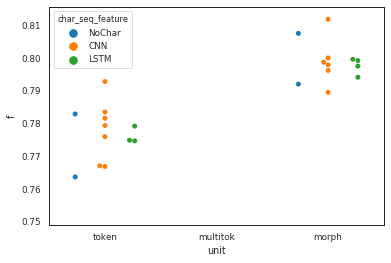

In [259]:
sns.swarmplot(data=erdf, x='unit', y='f', hue='char_seq_feature', dodge=True)


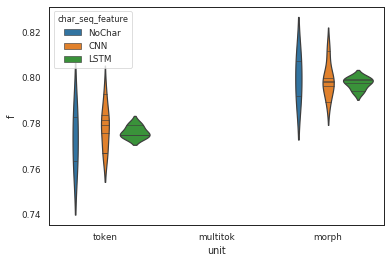

In [260]:
sns.violinplot(data=erdf, x='unit', y='f', hue='char_seq_feature', inner='stick')


## Learning rate

In [149]:
erdf.groupby(['optimizer', 'learning_rate', 'arch']).conf_num.nunique().unstack()

arch                     morph_charcnn  morph_charlstm  morph_nochar  \
optimizer learning_rate                                                
SGD       0.005                      7               4             2   
          0.010                     11               3             2   

arch                     multitok_charcnn  multitok_charlstm  multitok_nochar  \
optimizer learning_rate                                                         
SGD       0.005                         6                  4                2   
          0.010                        10                  4                2   

arch                     token_charcnn  token_charlstm  token_nochar  
optimizer learning_rate                                               
SGD       0.005                      8               4             2  
          0.010                      8               4             2

In [162]:
erdf.groupby(['learning_rate', 'arch']).f_dev.median().unstack()

arch,morph_charcnn,morph_charlstm,morph_nochar,multitok_charcnn,multitok_charlstm,multitok_nochar,token_charcnn,token_charlstm,token_nochar
learning_rate,,,,,,,,,
0.005,0.700855,0.701868,0.676624,0.722993,0.715782,0.693975,0.738070,0.735228,0.701699
0.010,0.711027,0.703920,0.685113,0.720079,0.725038,0.701445,0.741304,0.744703,0.696900


In [163]:
erdf.groupby(['learning_rate', 'arch']).f_dev.max().unstack()

arch,morph_charcnn,morph_charlstm,morph_nochar,multitok_charcnn,multitok_charlstm,multitok_nochar,token_charcnn,token_charlstm,token_nochar
learning_rate,,,,,,,,,
0.005,0.708779,0.705128,0.680663,0.728448,0.729989,0.695560,0.745223,0.752643,0.702128
0.010,0.717182,0.704641,0.689655,0.728832,0.736393,0.706499,0.747065,0.746554,0.701075


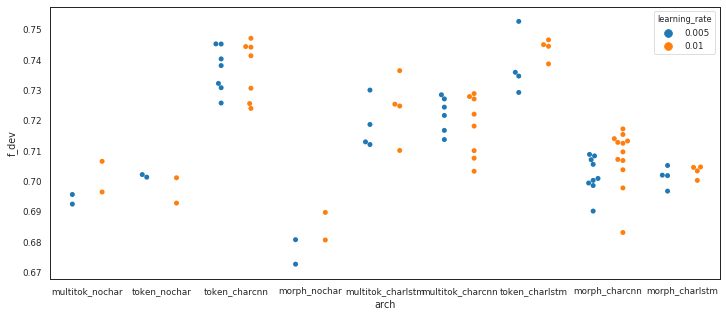

In [165]:
plt.figure(figsize=(12,5))
g = sns.swarmplot(data=erdf, hue='learning_rate', y='f_dev', x='arch', dodge=True)


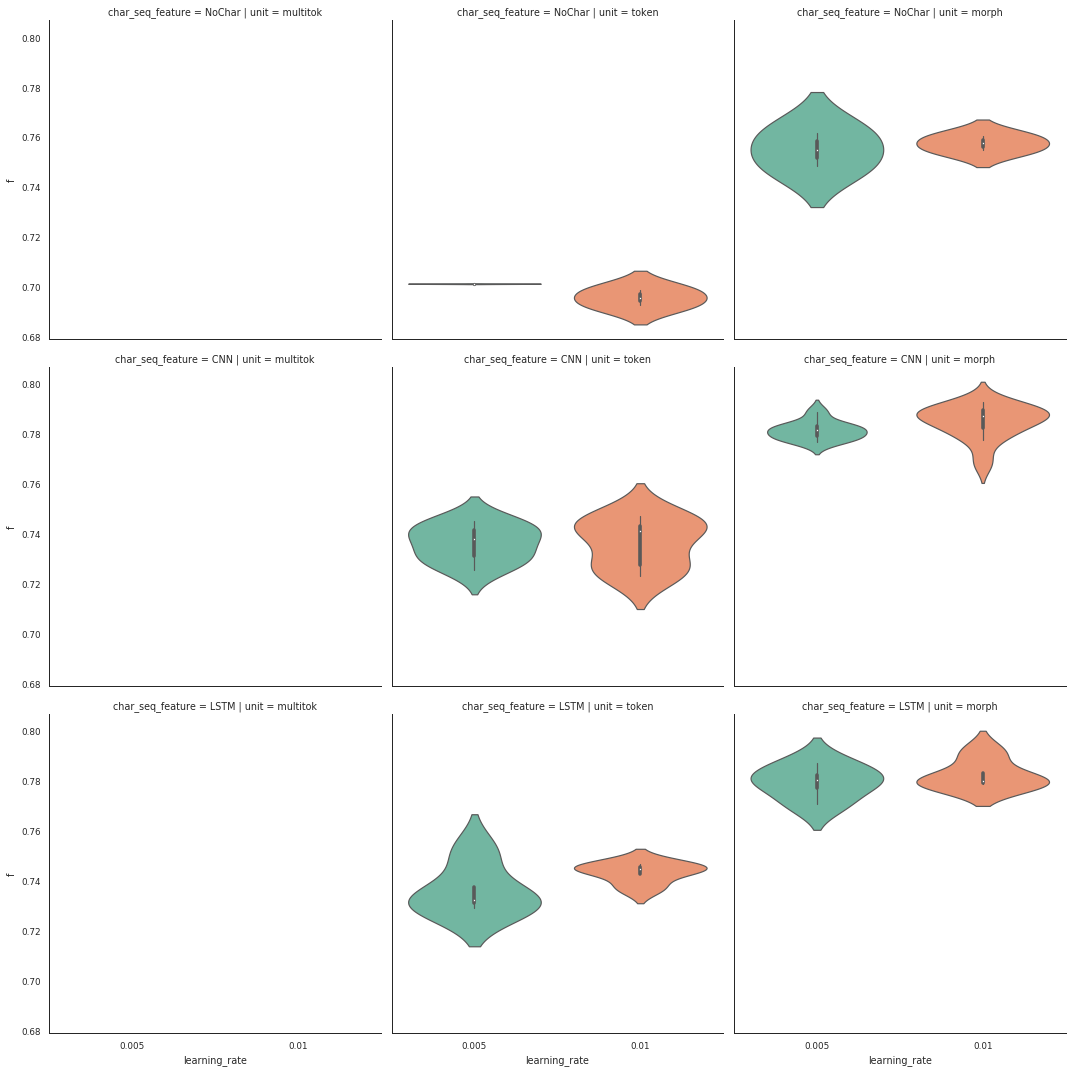

In [166]:
sns.catplot(kind='violin', row='char_seq_feature', col='unit', 
            x="learning_rate", y="f", #hue='batch_size',
                data=erdf, palette="Set2",
                scale="count", inner="box", scale_hue=True)

In [168]:
from scipy.stats import f_oneway

anov = {}
for a in erdf.arch.unique():
        anov[a] = f_oneway(erdf[(erdf.arch==a) & (erdf.learning_rate==0.005)].f_dev,
                             erdf[(erdf.arch==a) & (erdf.learning_rate==0.01)].f_dev,
                )
anov

{'multitok_nochar': F_onewayResult(statistic=1.988645827359238, pvalue=0.2939003694320607),
 'token_nochar': F_onewayResult(statistic=1.3075897286695641, pvalue=0.3712471987918794),
 'token_charcnn': F_onewayResult(statistic=0.00020882172540247072, pvalue=0.9887079156936306),
 'morph_nochar': F_onewayResult(statistic=1.9505374526941868, pvalue=0.29733381335491743),
 'multitok_charlstm': F_onewayResult(statistic=0.7129382079345106, pvalue=0.43084304976303867),
 'multitok_charcnn': F_onewayResult(statistic=0.7128069915208088, pvalue=0.41502830632489573),
 'token_charlstm': F_onewayResult(statistic=1.0822518980203222, pvalue=0.3382876132152238),
 'morph_charcnn': F_onewayResult(statistic=2.448507908287047, pvalue=0.1341399520680965),
 'morph_charlstm': F_onewayResult(statistic=0.7782604221686672, pvalue=0.41161894988405995)}

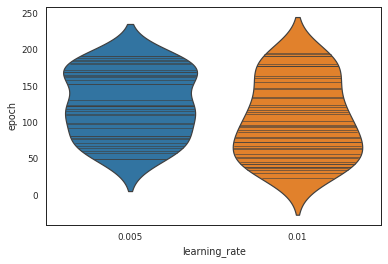

In [167]:
sns.violinplot(data=erdf, x='learning_rate', y='epoch', inner='stick')

### Do the lower scores in the lower learning rate come from lack of epochs?

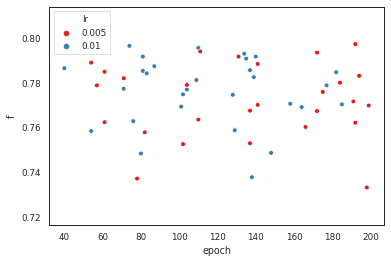

In [161]:
sns.scatterplot(data=erdf.assign(lr=lambda x: x.learning_rate.astype('str')), hue='lr', x='epoch', y='f',
               palette=sns.color_palette("Set1", erdf.learning_rate.nunique()))

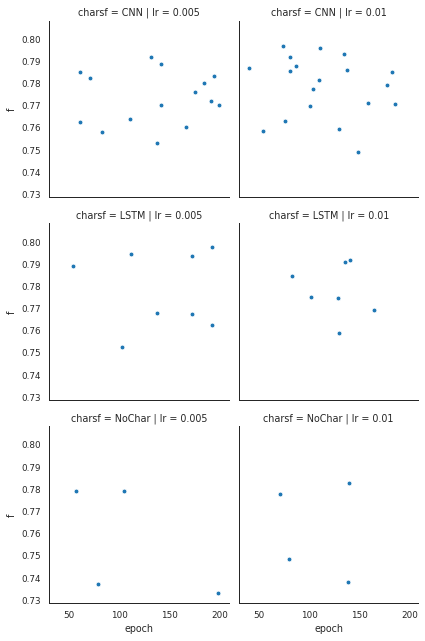

In [162]:
>>> g = sns.FacetGrid(erdf.rename(columns={'learning_rate': 'lr', 'char_seq_feature': 'charsf'}), col="lr", row='charsf')
>>> g = g.map(plt.scatter, "epoch", "f", edgecolor="w")

ValueError: The number of observations must be larger than the number of variables.

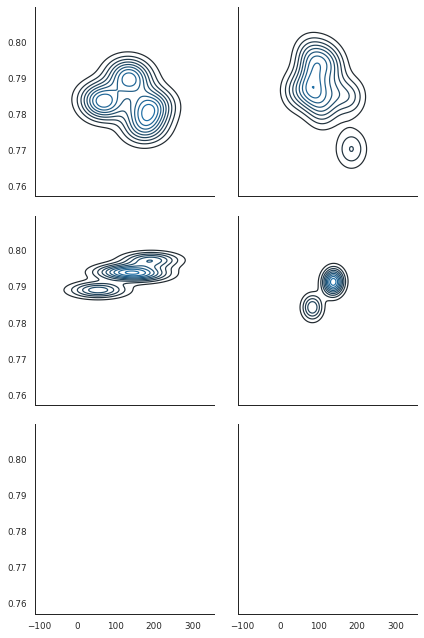

In [163]:
>>> g = sns.FacetGrid(erdf[erdf.unit=='morph'].rename(columns={'learning_rate': 'lr', 'char_seq_feature': 'charsf'}), col="lr", row='charsf')
>>> g = g.map(sns.kdeplot, "epoch", "f")

In [ ]:
>>> g = sns.FacetGrid(erdf[erdf.unit=='token'].rename(columns={'learning_rate': 'lr', 'char_seq_feature': 'charsf'}), col="lr", row='charsf')
>>> g = g.map(sns.kdeplot, "epoch", "f")

In [ ]:
>>> g = sns.FacetGrid(erdf.rename(columns={'char_seq_feature': 'charsf'}), col="batch_size", row='charsf')
>>> g = g.map(plt.scatter, "epoch", "f", edgecolor="w")

In [ ]:
>>> g = sns.FacetGrid(erdf.rename(columns={'char_seq_feature': 'charsf'}), col="batch_size", row='charsf')
>>> g = g.map(sns.kdeplot, "epoch", "f")

In [ ]:
sns.swarmplot(data=erdf, x='arch', y='epoch')

## Char CNN window size

In [172]:
erdf.groupby(['unit', 'char_kernel_size']).f.mean().unstack()

char_kernel_size,3.0,5.0,7.0
unit,,,
morph,0.781314,0.785529,0.783514
multitok,NaN,NaN,NaN
token,0.734050,0.738960,0.735460


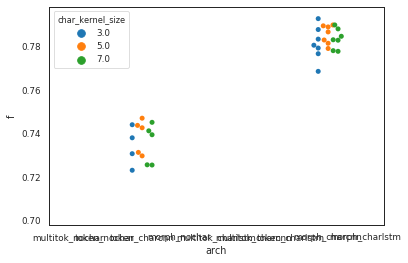

In [173]:
sns.swarmplot(data=erdf, x='arch', y='f', hue='char_kernel_size', split=True)


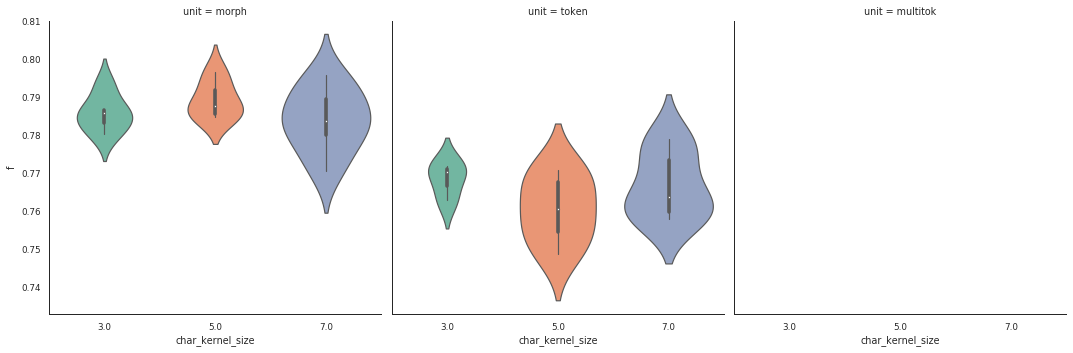

In [167]:
sns.catplot(kind='violin', col='unit', x="char_kernel_size", y="f",
                data=erdf, palette="Set2", 
                scale="count", inner="box")

## LSTM Layers stacked

In [2431]:
erdf.groupby(['lstm_layer', 'arch']).f.median().unstack()

arch,morph_charcnn,morph_charlstm,morph_nochar,token_charcnn,token_charlstm,token_nochar
lstm_layer,,,,,,
1,0.7772,0.7811,0.7751,0.74510,0.7519,0.72890
2,0.7809,0.7861,0.7719,0.75225,0.7594,0.73055


In [2432]:
erdf.groupby(['lstm_layer', 'arch']).f.max().unstack()

arch,morph_charcnn,morph_charlstm,morph_nochar,token_charcnn,token_charlstm,token_nochar
lstm_layer,,,,,,
1,0.7914,0.7966,0.7852,0.7666,0.7618,0.7424
2,0.7991,0.7974,0.7835,0.7749,0.7766,0.7476


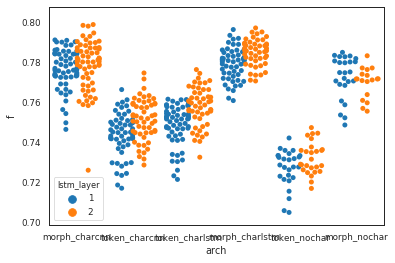

In [2433]:
sns.swarmplot(data=erdf, x='arch', y='f', hue='lstm_layer', split=True)


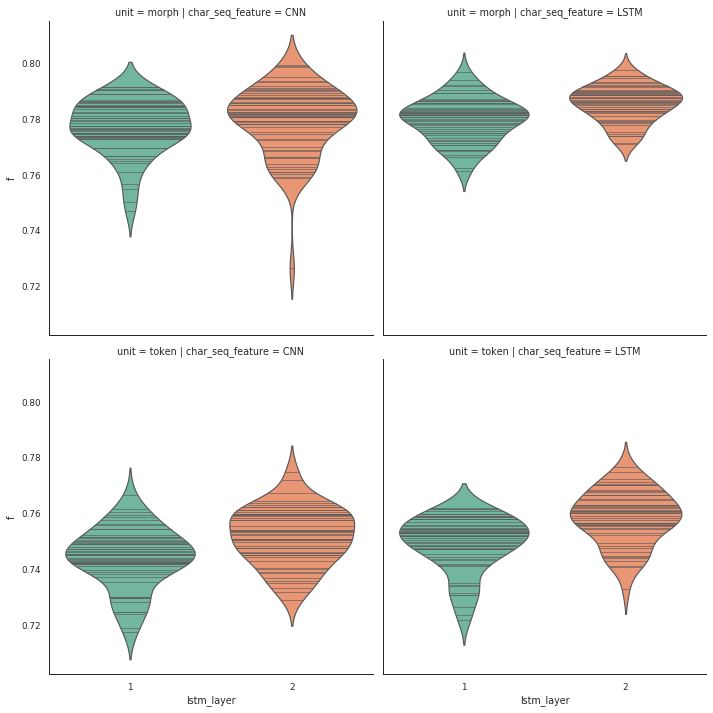

In [2434]:
sns.catplot(kind='violin', row='unit', col='char_seq_feature', 
            x="lstm_layer", y="f",
                data=erdf, palette="Set2", split=True,
                scale="count", inner="stick", scale_hue=True)

## Dropout

In [2435]:
erdf.groupby(['dropout', 'arch']).f.median().unstack()

arch,morph_charcnn,morph_charlstm,morph_nochar,token_charcnn,token_charlstm,token_nochar
dropout,,,,,,
0.4,0.7846,0.78210,0.7762,0.7524,0.7521,0.73045
0.5,0.7804,0.78345,0.7760,0.7492,0.7578,0.72930
0.6,0.7722,0.78090,0.7612,0.7422,0.7552,0.73020


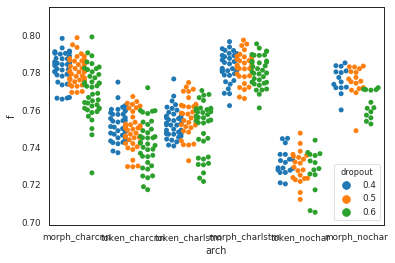

In [2436]:
sns.swarmplot(data=erdf, x='arch', y='f', hue='dropout', split=True)


## Hidden dimensions

### CLSTM / CCNN

In [2439]:
erdf.groupby(['char_hidden_dim', 'arch']).f.median().unstack()

arch,morph_charcnn,morph_charlstm,token_charcnn,token_charlstm
char_hidden_dim,,,,
50.0,0.7819,0.78395,0.7465,0.75485
70.0,0.7772,0.78200,0.7513,0.75190
90.0,0.7803,0.78220,0.7467,0.75600


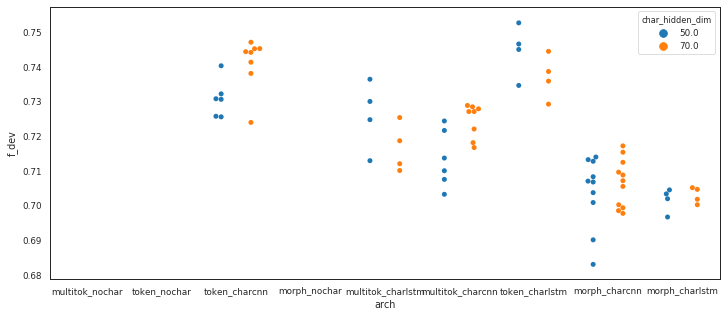

In [169]:
plt.figure(figsize=(12,5))
sns.swarmplot(data=erdf, x='arch', y='f_dev', hue='char_hidden_dim', split=True)

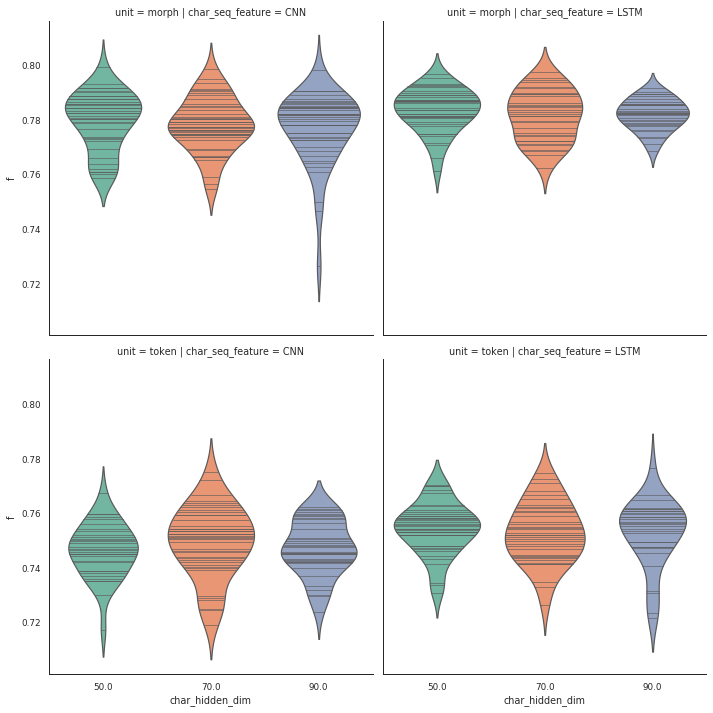

In [2441]:
sns.catplot(kind='violin', row='unit', col='char_seq_feature', 
            x="char_hidden_dim", y="f",
                data=erdf, palette="Set2", split=True,
                scale="count", inner="stick", scale_hue=True)

In [170]:
relevant_cols = ['arch', 'f_dev', 'char_hidden_dim', 'char_kernel_size', 'learning_rate']

In [171]:
erdf[relevant_cols].groupby('arch').apply(lambda x: x.sort_values('f_dev', ascending=False).head(2))

arch     f_dev  char_hidden_dim  \
arch                                                                 
morph_charcnn     33      morph_charcnn  0.717182             70.0   
                  69      morph_charcnn  0.715360             70.0   
morph_charlstm    52     morph_charlstm  0.705128             70.0   
                  65     morph_charlstm  0.704641             70.0   
morph_nochar      31       morph_nochar  0.689655              NaN   
                  17       morph_nochar  0.680663              NaN   
multitok_charcnn  46   multitok_charcnn  0.728832             70.0   
                  67   multitok_charcnn  0.728448             70.0   
multitok_charlstm 29  multitok_charlstm  0.736393             50.0   
                  4   multitok_charlstm  0.729989             50.0   
multitok_nochar   0     multitok_nochar  0.706499              NaN   
                  24    multitok_nochar  0.696391              NaN   
token_charcnn     35      token_charcnn  0.747065             70.0   
                  13      token_charcnn  0.745223             70.0   
token_charlstm    8      token_charlstm  0.752643             50.0   
                  51     token_charlstm  0.746554             50.0   
token_nochar      38       token_nochar  0.702128              NaN   
                  14       token_nochar  0.701271              NaN   

                      char_kernel_size  learning_rate  
arch                                                   
morph_charcnn     33               3.0          0.010  
                  69               7.0          0.010  
morph_charlstm    52               NaN          0.005  
                  65               NaN          0.010  
morph_nochar      31               NaN          0.010  
                  17               NaN          0.005  
multitok_charcnn  46               5.0          0.010  
                  67               5.0          0.005  
multitok_charlstm 29               NaN          0.010  
                  4                NaN          0.005  
multitok_nochar   0                NaN          0.010  
                  24               NaN          0.010  
token_charcnn     35               5.0          0.010  
                  13               7.0          0.005  
token_charlstm    8                NaN          0.005  
                  51               NaN          0.010  
token_nochar      38               NaN          0.005  
                  14               NaN          0.005

In [2443]:
rdf[rdf.groupby('arch').f.transform(max)==rdf.f].sort_values('f', ascending=False).T

,17957,13826,40290,9968,50194,44894
acc,0.97,0.9679,0.9666,0.9668,0.9655,0.9623
p,0.8558,0.8519,0.8612,0.8277,0.8424,0.8137
r,0.7495,0.7495,0.7214,0.7315,0.7174,0.6914
f,0.7991,0.7974,0.7852,0.7766,0.7749,0.7476
arch,morph_charcnn,morph_charlstm,morph_nochar,token_charlstm,token_charcnn,token_nochar
unit,morph,morph,morph,token,token,token
conf_num,017,011,071,017,075,014
word_seq_feature,LSTM,LSTM,LSTM,LSTM,LSTM,LSTM
word_emb_dim,300,300,300,300,300,300
char_emb_dim,30,30,30,30,30,30
